In [48]:
from math import exp, sqrt, sin, cos
import itertools
import csv

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import fsolve, curve_fit

In [2]:
def arrays_to_csv(array1, array2, name):
    with open(f"{name}.csv", "w", newline="") as file:
        writer = csv.writer(file)
        for a1, a2 in zip(array1, array2):
            writer.writerow([round(a1, 5), a2])

## Konstante i osnovne funkcije

In [ ]:
kb = 8.6173303 * 10 ** (-5)
hbar = 6.582119569 * 10 ** (-16)
pi = np.pi

alpha_op = 0.4
alpha_ac = 1
hbar_w_op = 0.02
eta_0 = 5 * 10 ** (-3)
M = 0.0
Kf_20 = 0.26  # eV, Fermi at 20K
vf = 4 * 10**5
a = 100 ** (1 / 3) * 10 ** (-10)
T_0 = 20


Ef = sqrt(Kf_20**2 + M**2)
Kf_ = Kf_20 / hbar / vf * a  # Fermi unitless
Kf_max = 1 / hbar / vf * a  # cutoff 1eV unitless
c_s_tilde = 0.03  # hbar_w_ac_max / hbar / vf * a
hbar_w_ac_max = (
    c_s_tilde * hbar * vf / a
)
G_op2 = alpha_op
G_ac2 = alpha_ac * hbar * vf / a

print(c_s_tilde)
print(hbar_w_ac_max)

0.03
0.017016896080069573


In [7]:
def fermi_dirac(E, Ef, T):
    if T > 0:
        if E > Ef:
            return exp((-E + Ef) / (kb * T)) / (exp((-E + Ef) / (kb * T)) + 1)
        else:
            return 1 / (exp((E - Ef) / (kb * T)) + 1)
    else:
        if E > Ef:
            return 0
        else:
            return 1


def bose_einstein(E, T):
    assert T > 0
    return exp(-E / (kb * T)) / (-exp(-E / (kb * T)) + 1)


def chemical_potential(T):
    return (
        Ef
        - pi**2 / 6 * (2 * Ef**2 - M**2) / Ef / (Ef**2 - M**2) * (kb * T) ** 2
        - 7 / 360 * pi**4 * 3 * M**4 / Ef / (Ef**2 - M**2) ** 3 * (kb * T) ** 4
    )  # Sommerfield approx.


#    return abs(fsolve(particle_density_int, 0.55, args=(M,Kf,T))[0]) # use this for exact value


def particle_density(E, Ef, M, T):
    g = E * sqrt(E**2 - M**2) / pi**2 / (hbar * vf) ** 3
    fs = -fermi_dirac(E, -Ef, T) + fermi_dirac(E, Ef, T)
    return g * fs


def particle_density_int(u, M, Kf, T):
    na = 1 / 3 / pi**2 * Kf**3 / (vf * hbar) ** 3
    return na - integrate.quad(particle_density, M, 7, args=(u, M, T), limit=80000)[0]


def eps(K):
    return sqrt(hbar**2 * vf**2 / a**2 * K**2 + M**2)  # K dimensionless

In [25]:
ws_0 = np.arange(0, 0.1, 0.001)


def calculate_integral_points(
    mem_fn, real_sum, imag_sum, hbar_w_ph, T=T_0, eta=eta_0, ws=ws_0, u=Kf_20
):

    result_real = []

    result_imag = []

    for w in ws:

        result_real.append(
            mem_fn(
                real_sum,
                w,
                hbar_w_ph,
                u,
                T=T,
                eta=eta,
            )
        )

        result_imag.append(
            mem_fn(
                imag_sum,
                w,
                hbar_w_ph,
                u,
                T=T,
                eta=eta,
            )
        )

    return result_real, result_imag


def setup_plot(real=True, imag=True, x_lim=[0.0, 0.05], y_lim=[0, 0.06]):

    fig, ax1 = plt.subplots()

    ax1.set_xlabel(r"$\hbar \omega [eV]$")

    if real:

        ax1.set_ylabel(r"$\hbar Re\{M_x\} [eV]$")

    else:

        ax1.set_ylabel(r"$\hbar Im\{M_x\} [eV]$")

    ax1.set_xlim(x_lim)

    ax1.set_ylim(y_lim)

    ax2 = ax1.twinx()

    if imag and real:

        ax2.set_ylabel(r"$\hbar Im\{M_x\} [eV]$")

    ax2.set_xlim(x_lim)

    ax2.set_ylim(y_lim)

    return fig, ax1, ax2


def plot_real_and_imag_result(
    ax1, ax2, result_real, result_imag, T=None, eta=None, ws=ws_0
):
    assert T or eta

    ax1.plot(ws, result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV")

    ax2.plot(ws, result_imag)

    if T:

        plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)

    else:

        plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)


def plot_result(ax, result, T=None, eta=None, ws=ws_0):

    ax.plot(ws, result, label=f"T={T} K" if T else f"$\eta = $ {eta:.5f} eV")

<>:75: SyntaxWarning: invalid escape sequence '\e'
<>:81: SyntaxWarning: invalid escape sequence '\e'
<>:90: SyntaxWarning: invalid escape sequence '\e'
<>:75: SyntaxWarning: invalid escape sequence '\e'
<>:81: SyntaxWarning: invalid escape sequence '\e'
<>:90: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_3288\2914288484.py:75: SyntaxWarning: invalid escape sequence '\e'
  ax1.plot(ws, result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV")
C:\Users\Patrik\AppData\Local\Temp\ipykernel_3288\2914288484.py:81: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
C:\Users\Patrik\AppData\Local\Temp\ipykernel_3288\2914288484.py:90: SyntaxWarning: invalid escape sequence '\e'
  ax.plot(ws, result, label=f"T={T} K" if T else f"$\eta = $ {eta:.5f} eV")


## Optički fononi


**Memorijska funkcija**

In [39]:
def ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta):
    def summand(s1, s2):
        return (
            bose_einstein(hbar_w_ph, T) + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)
        ) / (hbar_w + s1 * Ef - s1 * eps(K) + s2 * hbar_w_ph + eta * 1j)

    sum = 0
    for s1, s2 in itertools.product([-1, 1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K**2


def ss_sum_real(K, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta).real


def ss_sum_imag(K, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta).imag


def mem_fn_op(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta):
    integral_k = integrate.quad(
        ss_sum_fn, 0, Kf_max, args=(hbar_w, hbar_w_ph, T, u, eta), limit=80000
    )[0]
    return (
        -G_op2 * integral_k / (2 * pi) ** 2 * 2
    )  # one factor 2 for 4\pi and one for two bands

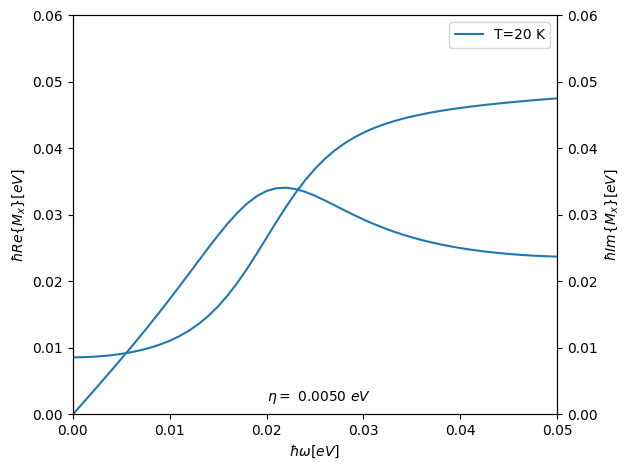

In [40]:
fig, *axs = setup_plot()
integrals = calculate_integral_points(mem_fn_op, ss_sum_real, ss_sum_imag, hbar_w_op)
arrays_to_csv(ws_0, integrals[0], f"op, real, T=20K, eta={eta_0}eV")
arrays_to_csv(ws_0, integrals[1], f"op, imag, T=20K, eta={eta_0}eV")
plot_real_and_imag_result(*axs, *integrals, T=T_0)
axs[0].legend(loc="best")
fig.tight_layout()

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_9012\752971007.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
C:\Users\Patrik\AppData\Local\Temp\ipykernel_9012\752971007.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)


TypeError: calculate_integral_points() missing 3 required positional arguments: 'real_sum', 'imag_sum', and 'hbar_w_ph'

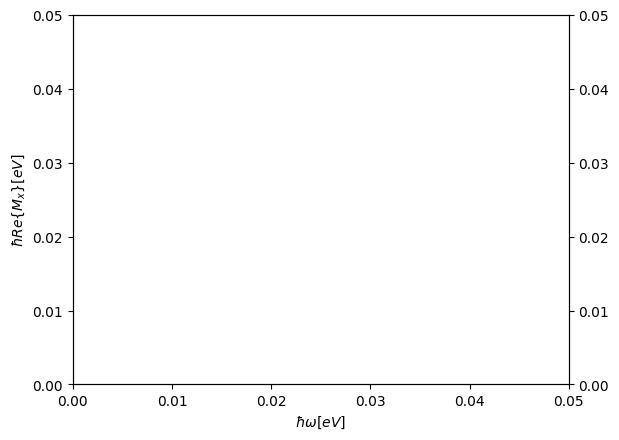

In [ ]:
fig, *axs = setup_plot(imag=False, y_lim=[0, 0.05])
ws_to_plot = np.arange(0, 0.05, 0.00025)
for T in [1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn_op, T=T, ws=ws_to_plot)
    plot_result(axs[0], integrals[0], T=T, ws=ws_to_plot)
    arrays_to_csv(ws_to_plot, integrals[0], f"op, T={T}K, eta={eta_0}eV")
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
fig.tight_layout()

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_8488\3542236707.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.020, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)


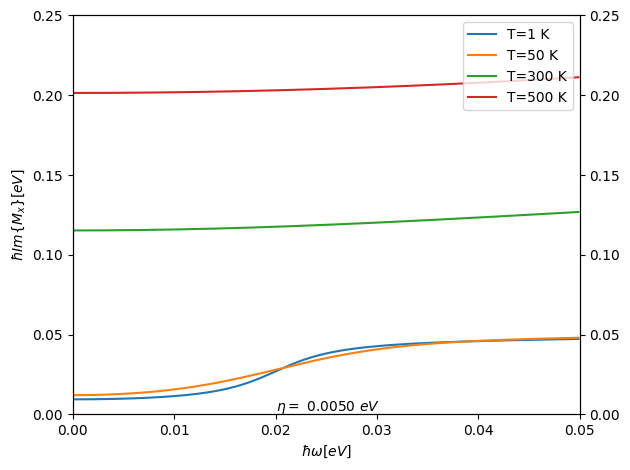

In [ ]:
fig, *axs = setup_plot(real=False, y_lim=[0, 0.25])
for T in [1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn, T=T)
    plot_result(axs[0], integrals[1], T=T)
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
fig.tight_layout()

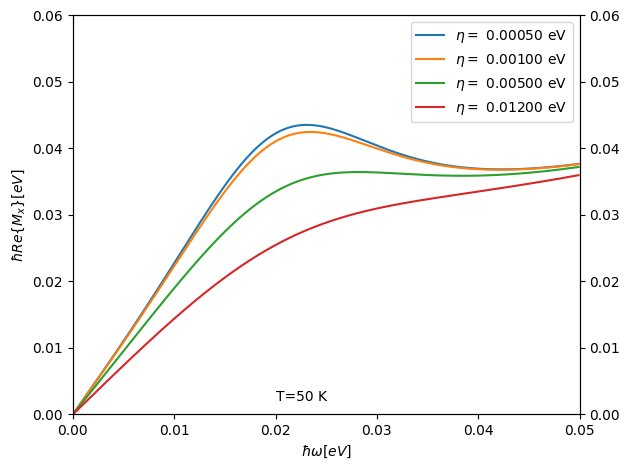

In [ ]:
fig, *axs = setup_plot(imag=False)
for eta in [0.0005, 0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn_op, eta=eta)
    plot_result(axs[0], integrals[0], eta=eta)
    arrays_to_csv(ws_0, integrals[0], f"op, T={T_0}K, eta={eta}eV")
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)
fig.tight_layout()

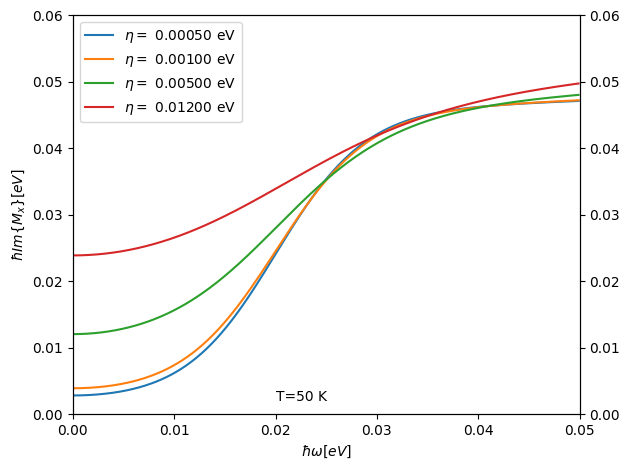

In [ ]:
fig, *axs = setup_plot(real=False)
for eta in [0.0005, 0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn, eta=eta)
    plot_result(axs[0], integrals[1], eta=eta)
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)
fig.tight_layout()

## Akustični fononi

In [16]:
def ss_sum_part_ac(K, theta, hbar_w, hbar_w_ph, T, u, eta):
    def summand(s1, s2):
        abs_K = sqrt(K**2 + Kf_**2 - 2 * Kf_ * K * cos(theta))
        factor = 1 - K * cos(theta) * Ef / eps(K) / Kf_
        return (
            (
                bose_einstein(hbar_w_ph * abs_K, T)
                + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)
            )
            / (hbar_w + s1 * Ef - s1 * eps(K) + s2 * hbar_w_ph * abs_K + eta * 1j)
            * abs_K
            * factor
        )

    sum = 0
    for s1, s2 in itertools.product([-1, 1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K**2 * sin(theta)


def ss_sum_real_ac(K, theta, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part_ac(K, theta, hbar_w, hbar_w_ph, T, u, eta).real


def ss_sum_imag_ac(K, theta, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part_ac(K, theta, hbar_w, hbar_w_ph, T, u, eta).imag


def mem_fn_ac(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta):
    integral_k_theta = integrate.nquad(
        ss_sum_fn,
        ([0, Kf_max], [0, pi]),
        args=(hbar_w, hbar_w_ph, T, u, eta),
        opts={"epsabs": 1.49 * 10 ** (-4), "epsrel": 1.49 * 10 ** (-4)},
    )[0]
    return -G_ac2 * integral_k_theta / (2 * pi) ** 2

**Memorijska funkcija**

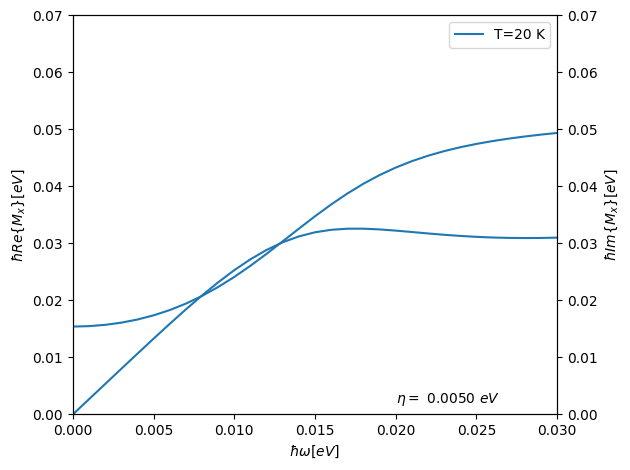

In [ ]:
fig, *axs = setup_plot(x_lim=[0, 0.03], y_lim=[0, 0.07])
integrals = calculate_integral_points(
    mem_fn_ac, ss_sum_real_ac, ss_sum_imag_ac, hbar_w_ac_max
)
plot_real_and_imag_result(*axs, *integrals, T=T_0)
arrays_to_csv(ws_0, integrals[0], f"ac, real, T=20K, eta={eta_0}eV")
arrays_to_csv(ws_0, integrals[1], f"ac, imag, T=20K, eta={eta_0}eV")
axs[0].legend(loc="best")
fig.tight_layout()

c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


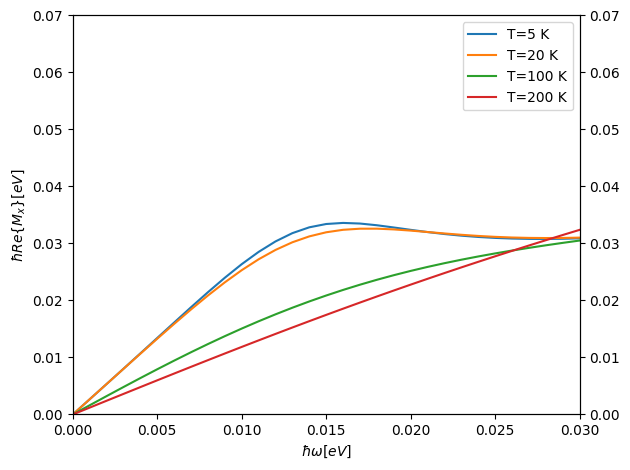

In [27]:
fig, *axs = setup_plot(imag=False, y_lim=[0, 0.07], x_lim=[0, 0.03])
for T in [5, 20, 100, 200]:
    integrals = calculate_integral_points(
        mem_fn_ac,
        ss_sum_real_ac,
        ss_sum_imag_ac,
        hbar_w_ac_max,
        T=T,
        u=chemical_potential(T),
    )
    plot_result(axs[0], integrals[0], T=T)
    # arrays_to_csv(w_to_plot, integrals[0], f"ac, T={T}K, eta={eta_0}eV")
axs[0].legend(loc="best")
# plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
fig.tight_layout()

c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


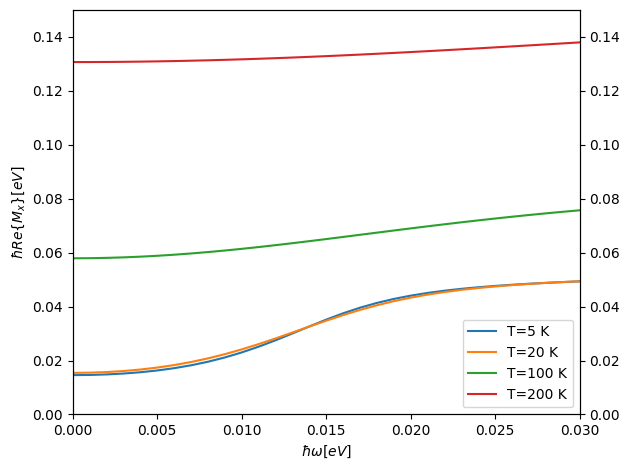

In [28]:
fig, *axs = setup_plot(imag=False, y_lim=[0, 0.15], x_lim=[0, 0.03])
for T in [5, 20, 100, 200]:
    integrals = calculate_integral_points(
        mem_fn_ac,
        ss_sum_real_ac,
        ss_sum_imag_ac,
        hbar_w_ac_max,
        T=T,
        u=chemical_potential(T),
    )
    plot_result(axs[0], integrals[1], T=T)
    # arrays_to_csv(w_to_plot, integrals[0], f"ac, T={T}K, eta={eta_0}eV")
axs[0].legend(loc="best")
# plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
fig.tight_layout()

In [45]:
Ts = np.linspace(0.0001, 100, 1000)


def M_T_dep(c_s, eta):
    res_real = []
    res_imag = []
    hbar_w_ac_ = c_s * hbar * vf / a
    for T in Ts:
        res_real.append(
            mem_fn_ac(
                ss_sum_real_ac, 0, hbar_w_ac_, u=chemical_potential(T), T=T, eta=eta
            )
        )
        res_imag.append(
            mem_fn_ac(
                ss_sum_imag_ac, 0, hbar_w_ac_, u=chemical_potential(T), T=T, eta=eta
            )
        )
        arrays_to_csv(Ts, res_real, f"M(T) real, ac, eta={eta}eV, c_s_tilde={c_s}")
        arrays_to_csv(Ts, res_imag, f"M(T) imag, ac, eta={eta}eV, c_s_tilde={c_s}")
    return res_real, res_imag

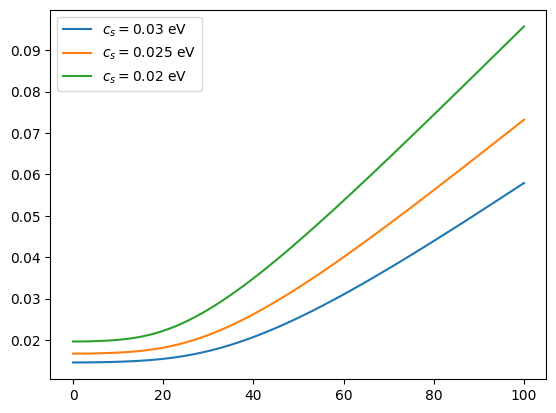

In [46]:
for c_s in [0.03, 0.025, 0.02]:
    res = M_T_dep(c_s, eta_0)
    plt.plot(Ts, res[1], label=f"$c_s={c_s}$ eV")
    plt.legend()

In [49]:
def read_to_array(name):
    with open(name, newline="") as csvfile:
        data = list(csv.reader(csvfile))
    return np.array(data)

In [50]:
def function_to_fit(T, b, a, x):
    return b + a * T**x

In [60]:
for c_s in [0.03, 0.025, 0.02]:
    results = read_to_array(f"M(T) imag, ac, eta={eta_0}eV, c_s_tilde={c_s}.csv")
    x_data = results[:, 0][:200]
    y_data = results[:, 1][:200]
    print(curve_fit(f=function_to_fit, xdata=x_data, ydata=y_data, p0=[0.01, 0, 2.5]))

(array([1.45524442e-02, 4.66141251e-07, 2.50674314e+00]), array([[ 5.96739560e-13, -7.40390014e-15,  5.18951024e-09],
       [-7.40390014e-15,  1.74883843e-16, -1.27148642e-10],
       [ 5.18951024e-09, -1.27148642e-10,  9.27391167e-05]]))
(array([1.66954390e-02, 5.29208695e-07, 2.63085884e+00]), array([[ 1.55673505e-12, -1.41121941e-14,  8.72899935e-09],
       [-1.41121941e-14,  2.51162580e-16, -1.61021701e-10],
       [ 8.72899935e-09, -1.61021701e-10,  1.03537355e-04]]))
(array([1.96322639e-02, 6.31017032e-07, 2.76974843e+00]), array([[ 3.09345450e-12, -1.96730400e-14,  1.02237844e-08],
       [-1.96730400e-14,  2.53993595e-16, -1.36695044e-10],
       [ 1.02237844e-08, -1.36695044e-10,  7.37667732e-05]]))


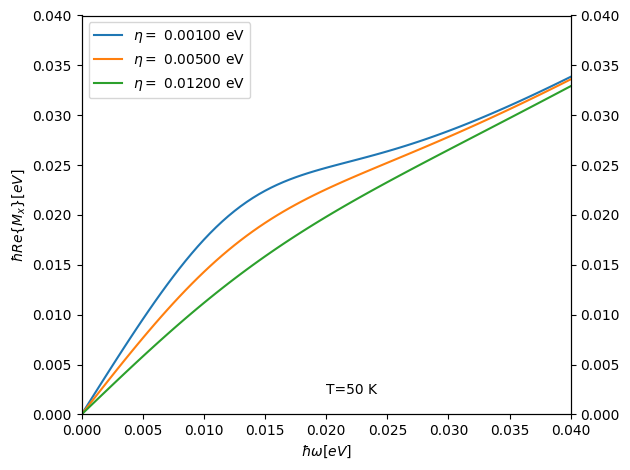

In [ ]:
fig, *axs = setup_plot(imag=False, y_lim=[0, 0.04], x_lim=[0, 0.04])
w_to_plot = np.arange(0, 0.0401, 0.0005)
for eta in [0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn_ac, eta=eta, ws=w_to_plot)
    plot_result(axs[0], integrals[0], eta=eta, ws=w_to_plot)
    arrays_to_csv(w_to_plot, integrals[0], f"ac, T={T_0}K, eta={eta}eV")
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)
fig.tight_layout()

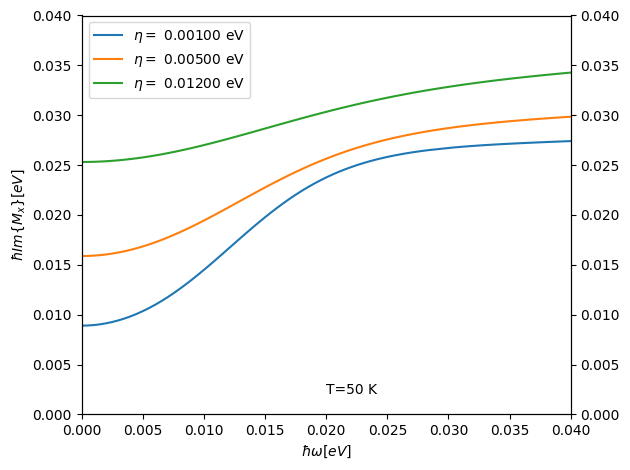

In [ ]:
fig, *axs = setup_plot(real=False, y_lim=[0, 0.04], x_lim=[0, 0.04])
w_to_plot = np.arange(0, 0.0401, 0.0005)
for eta in [0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn_ac, eta=eta, ws=w_to_plot)
    plot_result(axs[0], integrals[1], eta=eta, ws=w_to_plot)
axs[0].legend(loc="best")
plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)
fig.tight_layout()